In [1]:
from aorsa_cql_mcgo_toolkit.utils.MCGO_Analysis import MCGO_Post_Process, Orbit_Plotter
from aorsa_cql_mcgo_toolkit.utils.CQL3D_Analysis import CQL3D_Post_Process
import matplotlib.pyplot as plt
import numpy as np
import f90nml as f90
from scipy.interpolate import interp1d
from netCDF4 import Dataset

In [2]:
# Set up case 

mcgo_nc_file = None #'/home/jacobvandelindt/aorsa_cql_mcgo_toolkit/shots/147634/DIIID_FOW_RF_NBIreinj_147634_dt0014_reinj100ms_promptIncluded_ivlim30.nc'
eqdsk_file = '/home/jacobvandelindt/aorsa_cql_mcgo_toolkit/shots/147634/g147634.04525'

# create the pp object

mcgo_pp = MCGO_Post_Process(mcgo_nc_file=mcgo_nc_file, eqdsk_file=eqdsk_file, particle_lists_on=True)


['   90   86\n']


Rmin:  1.001
Rmax:  2.377


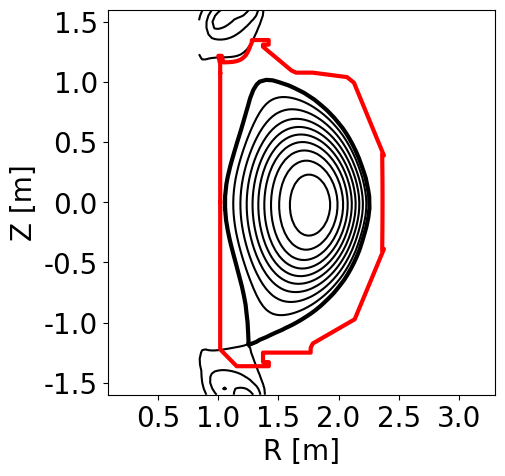

t_bounce 3.630359923550518e-05 [s]


In [3]:
print('Rmin: ', np.min(mcgo_pp.eqdsk['rlim']))
print('Rmax: ', np.max(mcgo_pp.eqdsk['rlim']))
mcgo_pp.plot_equilibrium(figsize=(5,5), levels=[.1,.2,.3,.4,.5,.6, .7,.8,.9,1])

R0 = 1
q = 2
mpart = 3.343e-27
Epart = 5 * 1000 * 1.6022e-19
t_bounce = 4*np.pi*R0*q/np.sqrt(2*Epart/mpart)
print(f't_bounce {t_bounce} [s]')

/home/jacobvandelindt/aorsa_cql_mcgo_toolkit/aorsa_env/lib/python3.8/site-packages/f90nml/parser.py:826: UserWarning: f90nml: warning: Value 0.0 is not assigned to any variable and has been removed.
  warnings.warn(
/home/jacobvandelindt/aorsa_cql_mcgo_toolkit/aorsa_env/lib/python3.8/site-packages/f90nml/parser.py:826: UserWarning: f90nml: warning: Value 5e+18 is not assigned to any variable and has been removed.
  warnings.warn(
/home/jacobvandelindt/aorsa_cql_mcgo_toolkit/aorsa_env/lib/python3.8/site-packages/f90nml/parser.py:826: UserWarning: f90nml: warning: Value 1e+16 is not assigned to any variable and has been removed.
  warnings.warn(
/home/jacobvandelindt/aorsa_cql_mcgo_toolkit/aorsa_env/lib/python3.8/site-packages/f90nml/parser.py:826: UserWarning: f90nml: warning: Value 7e+18 is not assigned to any variable and has been removed.
  warnings.warn(
/home/jacobvandelindt/aorsa_cql_mcgo_toolkit/aorsa_env/lib/python3.8/site-packages/f90nml/parser.py:826: UserWarning: f90nml: warn

Text(0.5, 1.0, 'Genray Shot Profiles')

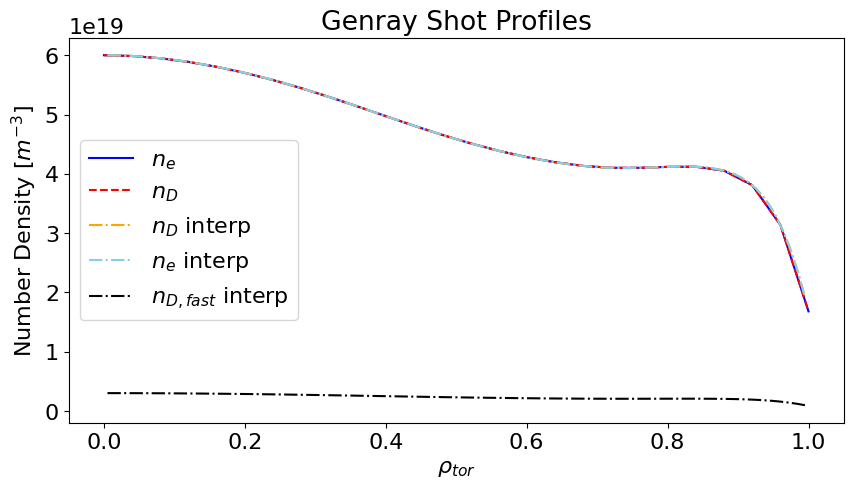

In [4]:
# set up ion and electron temp and density profiles 
rgrid_mcgo = np.linspace(5.0000e-03, 0.995, 100)

# read in genray profiles 
gnr_input_path = '/home/jacobvandelindt/aorsa_cql_mcgo_toolkit/shots/147634/genray.in'
gnr_nml = f90.read(gnr_input_path)
plt.rcParams.update({'font.size': 16})
dentab = gnr_nml['dentab']['prof']
den = np.array(dentab).reshape(26,3)
den_scale = gnr_nml['plasma']['den_scale']
ndens = gnr_nml['plasma']['ndens']
rgrid = np.linspace(0, 1, ndens)

# make ion and electron density interpolator 
fast_density_factor = 0.05 # TODO this is random
ne = den[:,0]*den_scale[0]
nD = den[:,1]*den_scale[1]
#nDfast = den[:,2]*den_scale[2]
fne = interp1d(rgrid, ne, kind='cubic')
fni = interp1d(rgrid, nD, kind='cubic')
fni_fast = interp1d(rgrid, nD*fast_density_factor, kind='cubic')

plt.figure(figsize=(10,5))
plt.plot(rgrid, ne, label=r'$n_e$', color='blue')
plt.plot(rgrid, nD, label=r'$n_D$', color='red', linestyle='dashed')
plt.plot(rgrid_mcgo, fni(rgrid_mcgo), label=r'$n_D$ interp', color='orange', linestyle='-.')
plt.plot(rgrid_mcgo, fne(rgrid_mcgo), label=r'$n_e$ interp', color='skyblue', linestyle='-.')
plt.plot(rgrid_mcgo, fni_fast(rgrid_mcgo), label=r'$n_{D,fast}$ interp', color='black', linestyle='-.')
#plt.plot(rgrid, nDfast, label=r'$n_{D, fast}$', color='orange')
plt.legend()
plt.xlabel(r'$\rho_{tor}$')
plt.ylabel(r'Number Density [$m^{-3}$]')
plt.title('Genray Shot Profiles')

Text(0.5, 1.0, 'Genray Shot Profiles')

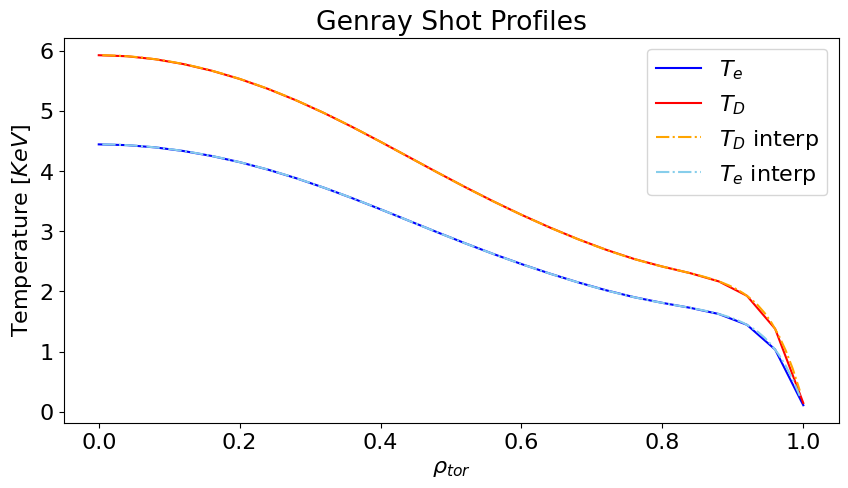

In [5]:
temtab = gnr_nml['temtab']['prof']
tem = np.array(temtab).reshape(26,3)
tem_scale = gnr_nml['plasma']['temp_scale']
ndens = gnr_nml['plasma']['ndens']
rgrid = np.linspace(0, 1, ndens)
Te = tem[:,0]*tem_scale[0]
TD = tem[:,1]*tem_scale[1]
TDfast = tem[:,2]*tem_scale[2]
fTe = interp1d(rgrid, Te, kind='cubic')
fTi = interp1d(rgrid, TD, kind='cubic')

plt.figure(figsize=(10,5))
plt.plot(rgrid, Te, label=r'$T_e$', color='blue')
plt.plot(rgrid, TD, label=r'$T_D$', color='red')
plt.plot(rgrid_mcgo, fTi(rgrid_mcgo), label=r'$T_D$ interp', color='orange', linestyle='-.')
plt.plot(rgrid_mcgo, fTe(rgrid_mcgo), label=r'$T_e$ interp', color='skyblue', linestyle='-.')
#plt.plot(rgrid, TDfast, label=r'$T_{D, fast}$', color='orange')
plt.legend()
plt.xlabel(r'$\rho_{tor}$')
plt.ylabel(r'Temperature [$KeV$]')
plt.title('Genray Shot Profiles')

In [4]:
# load up these profiles into the mcgo input file. 

# update densities and temperatures. 
infile = '/home/jacobvandelindt/aorsa_cql_mcgo_toolkit/shots/147634/mcgoinput_2speci'
outfile = '/home/jacobvandelindt/aorsa_cql_mcgo_toolkit/shots/147634/mcgoinput_2speci_out'

updates = {'rte': rgrid_mcgo.tolist(),
           'te': fTe(rgrid_mcgo).tolist(),
           'rti': rgrid_mcgo.tolist(),
           'ti': fTi(rgrid_mcgo).tolist(),
           'rni(1,1)': rgrid_mcgo.tolist(),
           'eni(1,1)': (fni_fast(rgrid_mcgo)/1e6).tolist(),
           'rni(1,2)': rgrid_mcgo.tolist(),
           'eni(1,2)': (fni(rgrid_mcgo)/1e6).tolist()} 

mcgo_pp.update_fortran_input_deck(input_file=infile, updates=updates, out_file=outfile)


NameError: name 'rgrid_mcgo' is not defined

In [6]:
# test of replacment of RF 
updates = {'RF_data_source': 'none'}
mcgo_pp.update_fortran_input_deck(input_file=outfile, updates=updates, out_file=outfile+'_test')


In [3]:
# Section 2: Post Processing
mcgo_nc_file = '/home/jacobvandelindt/aorsa_cql_mcgo_toolkit/temp_files/mcgo_out_iteration14.nc'
mcgo_pp.read_mcgo_nc(mcgo_nc_file=mcgo_nc_file)

In [4]:

print(mcgo_pp.rho_grid)
print(mcgo_pp.mcgo_nc.variables['radbnd'][:])
print(mcgo_pp.eqdsk['zmaxis'])
print(mcgo_pp.mcgo_nc.variables.keys())
print(mcgo_pp.mcgo_nc.variables['rend'].shape)

[0.99984086 0.9534368  0.89624786 0.82554513 0.7417133  0.64835364
 0.5519421  0.4580445  0.365512   0.26947647 0.16524976 0.05033564
 0.07436305 0.20521052 0.3386877  0.47434136 0.6137573  0.7516963
 0.8792598  0.9997565 ]
[1.0556841 1.118936  1.1821879 1.2454399 1.3086919 1.3719438 1.4351958
 1.4984477 1.5616996 1.6249516 1.6882036 1.7514555 1.8147074 1.8779594
 1.9412113 2.0044632 2.0677152 2.1309671 2.194219  2.257471 ]
-0.0231968987
dict_keys(['version', 'mnemonic', 'eqdskin', 'raxis', 'zaxis', 'xlimiter', 'ylimiter', 'rcontr', 'zcontr', 'nparts_tot', 'kep1', 'ipcount', 'anormal', 'mf', 'rhobincent', 'rps_bincent', 'npol_start', 'irbnd', 'ivbnd', 'iptchbnd', 'ptchbnd', 'vbnd', 'radbnd', 'psibin', 'rho_sqpolflx', 'vdstb', 'rst', 'zst', 'rend', 'zend', 'vparend', 'vperend', 'ivparini'])
(763149,)


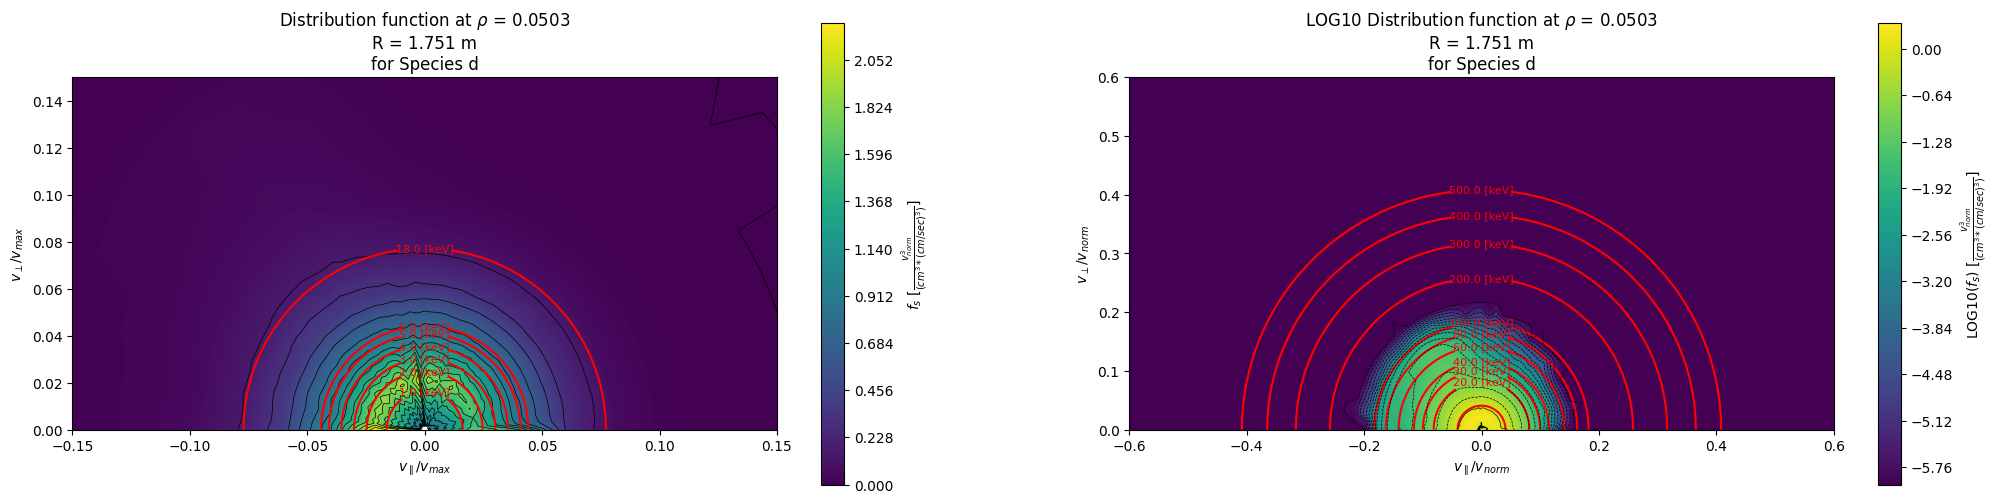

In [5]:
# try out plotting
rho_idx = 11
mcgo_pp.plot_distribution_function_at_rho(
        rho_index=rho_idx,
        v_norm_over_v_max=0.15,
        log_scale_axis_multiple=4,
        log_clip_level=1e-6,
        figsize=(25, 6),
        cmap="viridis",
        num_energy_levels=6,
        energy_levels_linear=[1,2,3,4,5,6, 18],
        energy_levels_log=[5, 20, 30, 40, 60, 80, 100, 200, 300, 400, 500],
        energy_color="red",
        return_plot=False,
        use_interpolated_rho=False,
        rho_to_interpolate_to=None,
        plot_trapped_passing=False)

vnorm: 16953142.0
vnorm: 5.6510473333333335 percent C
mion: 3.343583e-27
2998.9265244419244
Maximum f: 0.11300055682659149


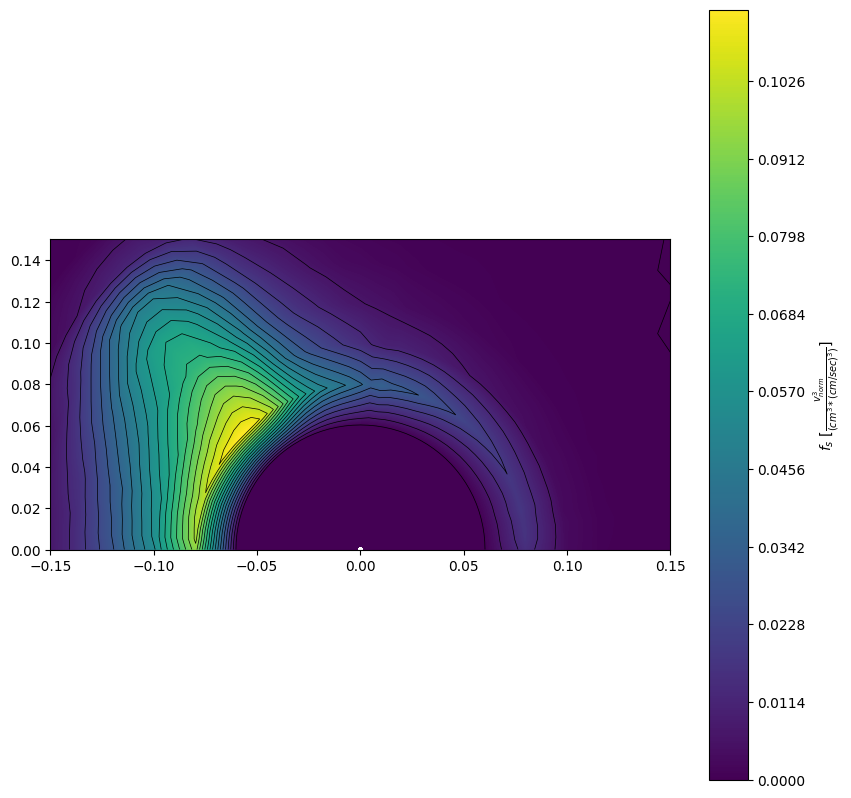

In [18]:
# only plot above an energy threshold to compare to p2f 
E_threshold_kev = 18
v_norm_over_v_max = 0.15
f_s_rho, VPAR, VPERP = mcgo_pp.get_distribution_function_at_rho(rho_idx)
f_s_rho = f_s_rho.copy()
vnorm_mks = mcgo_pp.vmax
mion = mcgo_pp.species_dict[mcgo_pp.species]['mass']
print(f'vnorm: {vnorm_mks}')
print(f'vnorm: {vnorm_mks/3e8 * 100} percent C')
print(f'mion: {mion}')
Em = 0
for i in range(f_s_rho.shape[0]):
    for j in range(f_s_rho.shape[1]):
        vperp = VPERP[i,j]
        vpar = VPAR[i,j]
        E = 0.5*(vperp**2 + vpar**2)*mion/1.6022e-19/1000
        if E > Em:
            Em = E
        if E < E_threshold_kev:
            f_s_rho[i,j] = 0
print(Em)
fig, ax = plt.subplots(figsize=(10,10))
c1 = ax.contourf(VPAR/mcgo_pp.vmax, VPERP/mcgo_pp.vmax, f_s_rho, levels=400)
ax.contour(VPAR/mcgo_pp.vmax, VPERP/mcgo_pp.vmax, f_s_rho, levels=20, colors='black', linewidths=0.5)
ax.set_xlim([-v_norm_over_v_max, v_norm_over_v_max])
ax.set_ylim([0, v_norm_over_v_max])
ax.set_aspect('equal')
print(f'Maximum f: {np.max(f_s_rho)}')
fig.colorbar(
    c1, ax=ax, label=r"$f_s$ [$\frac{v_{norm}^3}{(cm^3*(cm/sec)^3)}$]"
)

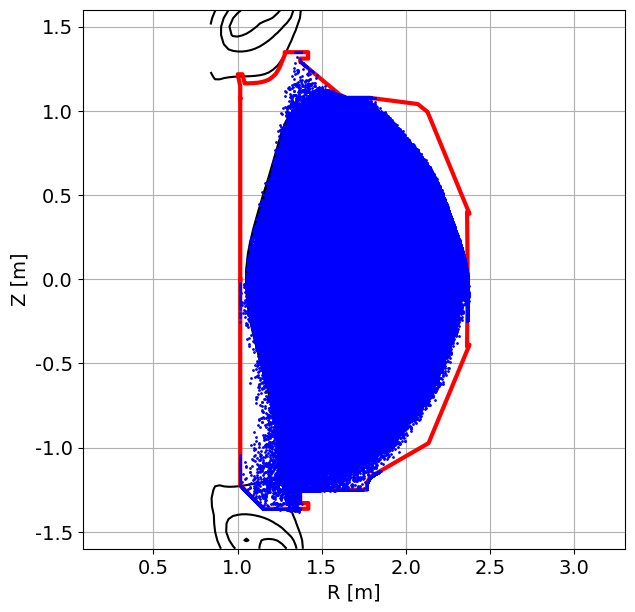

In [19]:
mcgo_pp.plot_particle_end_RZ(figsize=(7,7), levels=[.1,.2,.3,.4,.5,.6, .7,.8,.9,1], fontsize=14, dotsize=2, return_plot=False)

In [9]:
print(mcgo_pp.weight_factors[:])
print(mcgo_pp.kep1[:])
print(mcgo_pp.ipcount[:])
print(sum(mcgo_pp.ipcount[:]))

[5.7195885e+14 7.9297048e+14 1.1894563e+15 0.0000000e+00]
4
[459859 178754 124536      0]
763149


In [10]:
float(mcgo_pp.ipcount[0])

459859.0

In [10]:
# now, lets try and generate the p2f particle list, run p2f, and then plot the results here! 
filename='/home/jacobvandelindt/aorsa_cql_mcgo_toolkit/shots/147634/mcgo_p2f_plist.nc'
#weight = 1e13
weights = np.array([float(mcgo_pp.weight_factors[0])]*int(mcgo_pp.ipcount[0]) + \
          [float(mcgo_pp.weight_factors[1])]*int(mcgo_pp.ipcount[1]) + \
          [float(mcgo_pp.weight_factors[2])]*int(mcgo_pp.ipcount[2]))
print(f'weights has shape {weights.shape}')
print(f'Particle list length: {mcgo_pp.rend.shape}')
mcgo_pp.p2f_convert_mcgo_particle_list_to_p2f_particle_list(filename, weight=weights)

weights has shape (763149,)
Particle list length: (763149,)
File saved to /home/jacobvandelindt/aorsa_cql_mcgo_toolkit/shots/147634/mcgo_p2f_plist.nc
Number of particles: 763149


In [11]:
print(weights)

[5.71958849e+14 5.71958849e+14 5.71958849e+14 ... 1.18945630e+15
 1.18945630e+15 1.18945630e+15]


In [68]:
# slowing down time math
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Section for computing the slwoing down time for a beam of particles against a thermal background
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
pi = np.pi
epsi0 = 8.8541e-12
mD = 3.3435e-27
m_alpha = 6.644657e-27
me = 9.11e-31
e = 1.6022e-19

def nu_be(vb, Te, ne, Zb, mb):
    """
    vb: beam velocity [m/s]
    Te: electron thermal background temperature [KeV]
    ne: electron thermal background density [m^-3]
    Zb: charge of the beam nucleus 
    mb: beam nuclear mass [kg]

    This function assumes vb^3 << v_the^3, the thermal electron velocity. Good up to alpha particles 
    Freidberg PPFE Equation 9.64 
    """
    Te_J = Te*1.6022e-19*1000  # convert to KeV to eV and then to J
    prefactor = 1 / (3*(2*pi)**(3/2))
    bot = epsi0**2*mb*Te_J**(3/2)
    top = Zb**2*e**4*me**0.5
    LAMDA = 12*pi*epsi0**(3/2)*Te_J**(3/2)/(ne**0.5*e**3)
    return prefactor*top*np.log(LAMDA)*ne/bot * (vb/vb)

def nu_bi(vb, Ti, ni, Zb, mb, mi):
    """
    vb: beam velocity [m/s]
    Ti: ion thermal background temperature [KeV]
    ni: ion thermal background density [m^-3]
    Zb: charge of the beam nucleus 
    mb: beam nuclear mass [kg]
    """
    mr = mb*mi/(mb + mi)
    Ti_J = Ti*1.6022e-19*1000  # convert KeV to eV and then to J
    vTi = np.sqrt(2*Ti_J/mi)
    prefactor = 1 / (4*pi)
    bot = epsi0**2*mb*mr
    top = Zb**2*e**4*ni
    LAMDA = 12*pi*epsi0**(3/2)*Ti_J**(3/2)/(ni**0.5*e**3)
    postfactor = 1 / (  vb**3  + 1.3*vTi**3 )
    return prefactor*top*np.log(LAMDA)*postfactor/bot

def get_beam_slowing_down_time(vb, T, n, Zb, mb, mi):
    """
    Given a thermal bulk temperature T and bulk density n, this function 
    calculates how long it takes a particle of velocity vb with charge Zb and mass mb 
    to thermalize with the bulk ions mb 

    I assume ne = ni and Te = Ti, bulk electrons and ions are in thermal equilibrium and quasineutral.  

    Based on PPFE Jeff Freidberg page 202/203
    """
    A = nu_be(vb, T, n, Zb, mb) # get the constant beam-electron collision rate
    mr = mb*mi/(mb + mi)
    Ti_J = T*1.6022e-19*1000  # convert KeV to eV and then to J
    vTi = np.sqrt(2*Ti_J/mi)
    #vT_alpha = np.sqrt(2*Ti_J/mb)
    vT_alpha = np.sqrt(2*18*1.6022e-19*1000/mb)
    prefactor = 1 / (4*pi)
    bot = epsi0**2*mb*mr
    top = Zb**2*e**4*n
    LAMDA = 12*pi*epsi0**(3/2)*Ti_J**(3/2)/(n**0.5*e**3)
    lnLAMDA = np.log(LAMDA)
    B = prefactor*top*lnLAMDA/bot
    C = 1.3*vTi**3
    
    # analytic solution to PPFE 9.62
    term1 = np.abs(A*vb**3 + A*C + B)   
    term2 = np.abs(A*vT_alpha**3 + A*C + B)
    t_top = B*np.log(term1/term2) + 3*A*C*np.log(np.abs(vb/vT_alpha)) 
    t_bot = 3*A**2*C + 3*A*B

    return t_top/t_bot



Thermalization time: 0.04655985362313518 seconds
tau_bi 0.1756310959304899
tau_be 0.5659222788371149


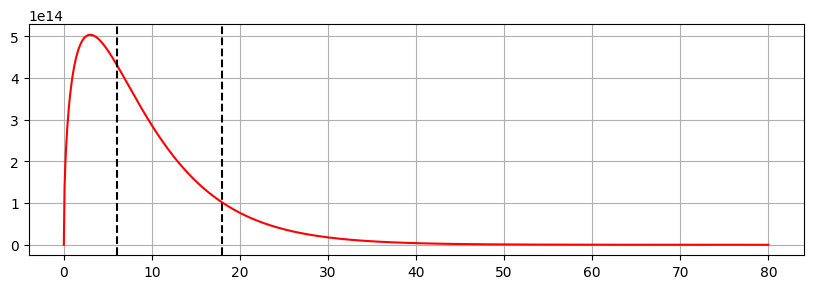

In [69]:
E_beam = 80e3 * 1.6022e-19
v_beam = np.sqrt(E_beam*2/mD)
time = get_beam_slowing_down_time(vb=v_beam, T=6, n=5e19, Zb=1, mb=mD, mi=mD)

print(f'Thermalization time: {time} seconds')

tau_be = 1/nu_be(vb=v_beam, Te=6, ne=5e19, Zb=1, mb=mD)
tau_bi = 1/nu_bi(vb=v_beam, Ti=6, ni=5e19, Zb=1, mb=mD, mi=mD)

print(f'tau_bi {tau_bi}')
print(f'tau_be {tau_be}')

def boltzman_E(E,T):
    # E,T are in keV
    e = 1.6022e-19
    E = E*1000*e
    T = T*1000*e
    return 2*np.sqrt(E/np.pi)*(1/T)**(3/2)*np.exp(-E/T)

Earray = np.linspace(0, 80, 1000)
f_E = boltzman_E(E=Earray, T=6)
fig, ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(Earray,f_E, color='red')
ax.grid()
ax.axvline(18, color='black', linestyle='--')
ax.axvline(6, color='black', linestyle='--')

In [29]:
# load p2f results 
p2f_out_file = '/home/jacobvandelindt/aorsa_cql_mcgo_toolkit/temp_files/p2f_out_iteration11.nc'

mcgo_pp.load_p2f_output(p2f_out_file=p2f_out_file)
print(mcgo_pp.p2f_out.variables.keys())
print(mcgo_pp.p2f_out.variables['vPar_binCenters'][:].shape)
print(mcgo_pp.p2f_out.variables['vPer_binCenters'][:].shape)
print(mcgo_pp.p2f_out.variables['R_binCenters'][:].shape)
print(mcgo_pp.p2f_out.variables['z_binCenters'][:].shape)
print(mcgo_pp.p2f_out.variables['f_rzvv'][:].shape)
print(mcgo_pp.p2f_out.variables['f_rzvv'].dimensions)
np.isnan(mcgo_pp.p2f_out.variables['f_rzvv'][:]).any()

print(mcgo_pp.p2f_out.variables['vPar_binCenters'][:])

dict_keys(['f_rzvv', 'R_binCenters', 'z_binCenters', 'vPer_binCenters', 'vPar_binCenters', 'R_binEdges', 'z_binEdges', 'vPer_binEdges', 'vPar_binEdges', 'nP', 'R_binSize', 'z_binSize', 'vPer_binSize', 'vPar_binSize', 'vPar_range', 'vPer_range', 'density'])
(129,)
(65,)
(128,)
(128,)
(129, 65, 128, 128)
('vPar_nBins', 'vPer_nBins', 'z_nBins', 'R_nBins')
[-1.1906977e+07 -1.1720930e+07 -1.1534884e+07 -1.1348837e+07
 -1.1162791e+07 -1.0976744e+07 -1.0790698e+07 -1.0604651e+07
 -1.0418605e+07 -1.0232558e+07 -1.0046512e+07 -9.8604650e+06
 -9.6744190e+06 -9.4883720e+06 -9.3023260e+06 -9.1162790e+06
 -8.9302330e+06 -8.7441860e+06 -8.5581400e+06 -8.3720925e+06
 -8.1860465e+06 -7.9999995e+06 -7.8139535e+06 -7.6279065e+06
 -7.4418600e+06 -7.2558135e+06 -7.0697670e+06 -6.8837205e+06
 -6.6976740e+06 -6.5116275e+06 -6.3255810e+06 -6.1395345e+06
 -5.9534880e+06 -5.7674415e+06 -5.5813950e+06 -5.3953485e+06
 -5.2093020e+06 -5.0232555e+06 -4.8372090e+06 -4.6511625e+06
 -4.4651160e+06 -4.2790695e+06 -4.0

In [25]:
#save working section to entire array 
f_python = np.transpose(mcgo_pp.p2f_out.variables['f_rzvv'][:], (3, 2, 1, 0))
Rarray = mcgo_pp.p2f_out.variables['R_binCenters'][:]
Zarray = mcgo_pp.p2f_out.variables['z_binCenters'][:]
vpar_array = mcgo_pp.p2f_out.variables['vPar_binCenters'][:]
vper_array = mcgo_pp.p2f_out.variables['vPer_binCenters'][:]

# 1. Check for literal NaNs
nan_mask = np.isnan(f_python)
if nan_mask.any():
    print(f"❌ Found {nan_mask.sum()} NaNs in raw data!")
    # Find where they are
    idx = np.where(nan_mask)
    print(f"First NaN at R_idx={idx[0][0]}, Z_idx={idx[1][0]}")

# 2. Check for Infinite values
inf_mask = np.isinf(f_python)
if inf_mask.any():
    print(f"❌ Found {inf_mask.sum()} Infs in raw data!")

# 3. Check for the "Zero Jacobian" at the vPer boundary
# If the first vPer bin has data but is effectively at 0 velocity
# if np.any(f_python[:, :, 0, :] > 0):
#     print("⚠️ Warning: Non-zero data detected at vPer=0. This often causes NaNs in AORSA.")
def check_4d_health(f, R, Z):
    # 1. Find the first slice that contains a NaN
    nans = np.isnan(f)
    if nans.any():
        bad_indices = np.where(nans)
        r_idx, z_idx = bad_indices[0][0], bad_indices[1][0]
        print(f"❌ FIRST NaN FOUND AT: R index {r_idx} ({R[r_idx]:.3f}m), Z index {z_idx} ({Z[z_idx]:.3f}m)")
    
    # 2. Check for the 'All Zeros' problem
    # Sometimes p2f produces slices of literal 0.0 or very small junk near boundaries
    # that cause the derivative denominator to look large or weird.
    slice_sums = np.sum(f, axis=(2, 3)) # Sum over velocity space
    zero_slices = np.where(slice_sums == 0)
    print(f"ℹ️ Number of spatial slices with zero density: {len(zero_slices[0])} of {f.shape[0]*f.shape[1]}")

    # 3. Check for the 'Boundary Cliff'
    # Check the very first and last R/Z indices
    edge_nans = np.isnan(f[0,:,:,:]).sum() + np.isnan(f[-1,:,:,:]).sum()
    if edge_nans > 0:
        print(f"⚠️ Warning: {edge_nans} NaNs found specifically on the R boundaries.")

# Run this on your f_python before saving
check_4d_health(f_python, Rarray, Zarray)

ℹ️ Number of spatial slices with zero density: 6171 of 16384


In [60]:
# load up cql3d f and fill everywhere 
cql3d_nc_file = "/home/jacobvandelindt/aorsa_cql_mcgo_toolkit/temp_files/cql3d_1.nc"
cql3d_krf_nc_file = "/home/jacobvandelindt/aorsa_cql_mcgo_toolkit/cql3d_krf001.nc"
cqlin_file = "/home/jacobvandelindt/aorsa_cql_mcgo_toolkit/shots/147634/cqlinput"

cql_pp = CQL3D_Post_Process(
    gen_species_names=["D", "e"],
    cql3d_nc_file=cql3d_nc_file,
    cql3d_krf_file=cql3d_krf_nc_file,
    eqdsk_file=eqdsk_file,
    cql_input_file=cqlin_file,
)

f_s_rho, VPAR, VPERP = cql_pp.get_species_distribution_function_at_rho(gen_species_index=0, rho_index=3)

print(f_s_rho.shape)
print(VPAR.shape)
print(VPERP.shape)

['   90   86\n']
(500, 240)
(500, 240)
(500, 240)


/home/jacobvandelindt/aorsa_cql_mcgo_toolkit/aorsa_env/lib/python3.8/site-packages/f90nml/parser.py:826: UserWarning: f90nml: warning: Value 0.01 is not assigned to any variable and has been removed.
  warnings.warn(
/home/jacobvandelindt/aorsa_cql_mcgo_toolkit/aorsa_env/lib/python3.8/site-packages/f90nml/parser.py:826: UserWarning: f90nml: warning: Value 100 is not assigned to any variable and has been removed.
  warnings.warn(
/home/jacobvandelindt/aorsa_cql_mcgo_toolkit/aorsa_env/lib/python3.8/site-packages/f90nml/parser.py:826: UserWarning: f90nml: warning: Value 0.1 is not assigned to any variable and has been removed.
  warnings.warn(
/home/jacobvandelindt/aorsa_cql_mcgo_toolkit/aorsa_env/lib/python3.8/site-packages/f90nml/parser.py:826: UserWarning: f90nml: warning: Value 0.14 is not assigned to any variable and has been removed.
  warnings.warn(
/home/jacobvandelindt/aorsa_cql_mcgo_toolkit/aorsa_env/lib/python3.8/site-packages/f90nml/parser.py:826: UserWarning: f90nml: warning:

vnorm 17656190.750591323 m/s


(-0.001, 0.001)

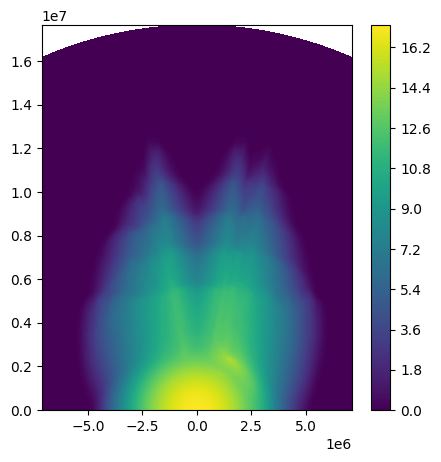

In [58]:
fig, ax = plt.subplots(figsize=(5,5))
vnorm = cql_pp.cql_nc.variables["vnorm"][:].data / 100
print(f'vnorm {vnorm} m/s')
cp = ax.contourf(VPAR*vnorm, VPERP*vnorm, np.log10(f_s_rho+1), levels=200)
fig.colorbar(cp)
ax.axis('equal')
ax.set_xlim(-0.001, 0.001)

In [67]:
# build an interpolator for the vleocity grid 
from scipy.interpolate import LinearNDInterpolator
points = np.column_stack(((VPAR*vnorm).ravel(), (VPERP*vnorm).ravel()))
values = f_s_rho.ravel()
f_interp = LinearNDInterpolator(points, values, fill_value=0.0)

vperp_array = np.linspace(0, vnorm, 65)
vpar_array = np.linspace(-vnorm, vnorm, 129)
f_fill = np.zeros((vperp_array.shape[0], vpar_array.shape[0]))

for ivperp in range(vperp_array.shape[0]):
    for ivpar in range(vpar_array.shape[0]):
        f_fill[ivperp, ivpar] =  f_interp(vpar_array[ivpar], vperp_array[ivperp])
        

vnorm 17656190.750591323 m/s


(-17656190.750591323, 17656190.750591323, 0.0, 17656190.750591323)

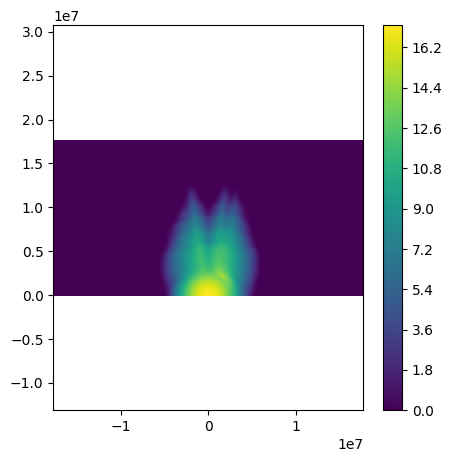

In [69]:
fig, ax = plt.subplots(figsize=(5,5))
vnorm = cql_pp.cql_nc.variables["vnorm"][:].data / 100
print(f'vnorm {vnorm} m/s')
cp = ax.contourf(vpar_array, vperp_array, np.log10(f_fill+1), levels=200)
fig.colorbar(cp)
ax.axis('equal')
#ax.set_xlim(-0.001, 0.001)

In [71]:
# refill with working slice 
f_save = np.zeros_like(f_python)
iR = 64
iZ = 64
for iiR in range(Rarray.shape[0]):
    for iiZ in range(Zarray.shape[0]):
        f_save[iiR,iiZ, :, :] = f_fill[:,:]

In [72]:
def write_f_rzvv_nc(filename, R_centers, Z_centers, vPer_centers, vPar_centers, f_rzvv):
    """
    Write f_rzvv to NetCDF in the same convention as p2f.

    Parameters
    ----------
    filename : str
        Output .nc filename
    R_centers, Z_centers, vPer_centers, vPar_centers : 1D arrays
        Bin centers
    f_rzvv : ndarray, shape (nR, nZ, nVper, nVpar)
        Distribution function in Python order [R, Z, vPer, vPar]
    """

    # Sanity checks
    nR, nZ, nVper, nVpar = f_rzvv.shape
    assert len(R_centers) == nR
    assert len(Z_centers) == nZ
    assert len(vPer_centers) == nVper
    assert len(vPar_centers) == nVpar

    # Convert to Fortran order for NetCDF
    # Python (R,Z,vPer,vPar) -> NetCDF (vPar,vPer,Z,R)
    f_to_save = np.transpose(f_rzvv, (3, 2, 1, 0))

    with Dataset(filename, "w", format="NETCDF4") as nc:
        # Dimensions
        nc.createDimension("R_nBins", nR)
        nc.createDimension("z_nBins", nZ)
        nc.createDimension("vPer_nBins", nVper)
        nc.createDimension("vPar_nBins", nVpar)

        nc.createDimension("R_nBins_p1", nR+1)
        nc.createDimension("z_nBins_p1", nZ+1)
        nc.createDimension("vPer_nBins_p1", nVper+1)
        nc.createDimension("vPar_nBins_p1", nVpar+1)

        nc.createDimension("scalar", 1)

        # Variables
        fvar = nc.createVariable("f_rzvv", "f4",
                                 ("vPar_nBins", "vPer_nBins", "z_nBins", "R_nBins"))
        Rvar = nc.createVariable("R_binCenters", "f4", ("R_nBins",))
        Zvar = nc.createVariable("z_binCenters", "f4", ("z_nBins",))
        vPervar = nc.createVariable("vPer_binCenters", "f4", ("vPer_nBins",))
        vParvar = nc.createVariable("vPar_binCenters", "f4", ("vPar_nBins",))

        # Assign data
        fvar[:, :, :, :] = f_to_save
        Rvar[:] = R_centers
        Zvar[:] = Z_centers
        vPervar[:] = vPer_centers
        vParvar[:] = vPar_centers

        # Example scalar metadata
        nc.createVariable("nP", "i4", ("scalar",))[:] = [0]
        nc.createVariable("R_binSize", "f4", ("scalar",))[:] = [R_centers[1]-R_centers[0]]
        nc.createVariable("z_binSize", "f4", ("scalar",))[:] = [Z_centers[1]-Z_centers[0]]
        nc.createVariable("vPer_binSize", "f4", ("scalar",))[:] = [vPer_centers[1]-vPer_centers[0]]
        nc.createVariable("vPar_binSize", "f4", ("scalar",))[:] = [vPar_centers[1]-vPar_centers[0]]

        # Optional: edges
        nc.createVariable("R_binEdges", "f4", ("R_nBins_p1",))[:] = np.linspace(R_centers[0], R_centers[-1], nR+1)
        nc.createVariable("z_binEdges", "f4", ("z_nBins_p1",))[:] = np.linspace(Z_centers[0], Z_centers[-1], nZ+1)
        nc.createVariable("vPer_binEdges", "f4", ("vPer_nBins_p1",))[:] = np.linspace(vPer_centers[0], vPer_centers[-1], nVper+1)
        nc.createVariable("vPar_binEdges", "f4", ("vPar_nBins_p1",))[:] = np.linspace(vPar_centers[0], vPar_centers[-1], nVpar+1)

        # Metadata
        nc.title = "Python-generated test f_rzvv, stored in Fortran-compatible order"

    print(f"✅ Wrote {filename} with f_rzvv shape {f_rzvv.shape} (Python) → {f_to_save.shape} (NetCDF)")

In [73]:
write_f_rzvv_nc(filename='cql3d_4df.nc', 
                R_centers=Rarray, 
                Z_centers=Zarray, 
                vPer_centers=vper_array, 
                vPar_centers=vpar_array,
                f_rzvv=f_save)

✅ Wrote cql3d_4df.nc with f_rzvv shape (128, 128, 65, 129) (Python) → (129, 65, 128, 128) (NetCDF)


In [18]:
mcgo_pp.p2f_out.variables

{'f_rzvv': <class 'netCDF4.Variable'>
 float32 f_rzvv(vPar_nBins, vPer_nBins, z_nBins, R_nBins)
 unlimited dimensions: 
 current shape = (129, 65, 128, 128)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'R_binCenters': <class 'netCDF4.Variable'>
 float32 R_binCenters(R_nBins)
 unlimited dimensions: 
 current shape = (128,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'z_binCenters': <class 'netCDF4.Variable'>
 float32 z_binCenters(z_nBins)
 unlimited dimensions: 
 current shape = (128,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'vPer_binCenters': <class 'netCDF4.Variable'>
 float32 vPer_binCenters(vPer_nBins)
 unlimited dimensions: 
 current shape = (65,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'vPar_binCenters': <class 'netCDF4.Variable'>
 float32 vPar_binCenters(vPar_nBins)
 unlimited dimensions: 
 current shape = (129,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'R_binEdges': <cla

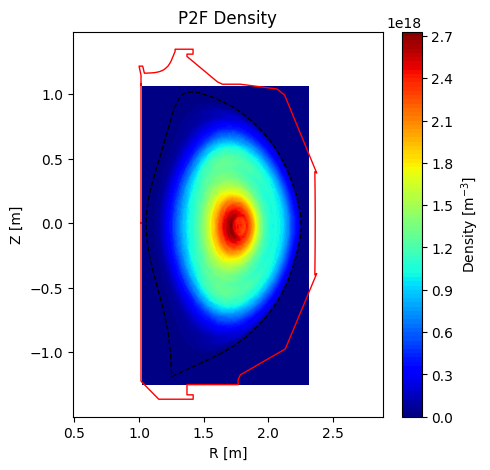

In [30]:
# plot the density
mcgo_pp.p2f_plot_density_RZ(figsize=(8,8))

In [55]:
# compare density to a manual creation to see if integration is correct 
def integrate_density(f_slice, vperp, vpar):
    """
    f_slice: 2D array f(vperp, vpar) at fixed (r,z)
    vperp, vpar: 1D arrays of grid points
    """
    # Compute spacings
    dvper = np.diff(vperp)
    dvpar = np.diff(vpar)

    # Meshgrid for midpoints
    vper_mid = 0.5 * (vperp[:-1] + vperp[1:])
    vpar_mid = 0.5 * (vpar[:-1] + vpar[1:])

    VPER, VPAR = np.meshgrid(vper_mid, vpar_mid, indexing="ij")

    # Take f at cell centers
    f_mid = 0.25 * (f_slice[:-1,:-1] + f_slice[1:,:-1] +
                    f_slice[:-1,1:] + f_slice[1:,1:])

    # Cell area
    dVper, dVpar = np.meshgrid(dvper, dvpar, indexing="ij")

    # Integral with 2π v_perp Jacobian
    n = np.sum(f_mid * (2*np.pi*VPER) * dVper * dVpar)
    return n

def read_f_rzvv_nc(filename):
    """
    Read f_rzvv from NetCDF (p2f convention) and return arrays in Python order:
        f_rzvv.shape = (nR, nZ, nVper, nVpar)

    Parameters
    ----------
    filename : str
        Path to .nc file

    Returns
    -------
    R_centers, Z_centers, vPer_centers, vPar_centers : 1D numpy arrays
    f_rzvv : 4D numpy array, shape (nR, nZ, nVper, nVpar)
    """
    with Dataset(filename, "r") as nc:
        R = nc.variables["R_binCenters"][:]
        Z = nc.variables["z_binCenters"][:]
        vPer = nc.variables["vPer_binCenters"][:]
        vPar = nc.variables["vPar_binCenters"][:]

        f_nc = nc.variables["f_rzvv"][:]  # stored as (vPar, vPer, Z, R)

    # Reorder to Python natural (R,Z,vPer,vPar)
    f_python = np.transpose(f_nc, (3, 2, 1, 0))

    return R, Z, vPer, vPar, f_python

def read_4df_and_save_density_2d(distribution_function_file, density_save_file):

    # read in the 4df file 
    R, Z, vPer, vPar, f_python = read_f_rzvv_nc(filename=distribution_function_file)
    nR = R.shape[0]
    nZ = Z.shape[0]

    # make storage data array
    density2d = np.zeros((nR,nZ))

    # loop over R, Z and integrate 
    for iR in range(nR):
        for iZ in range(nZ):
            f_slice = f_python[iR, iZ, :, :]
            density = integrate_density(f_slice=f_slice, vperp=vPer, vpar=vPar)
            density2d[iR, iZ] = density

    print('Done looping over f_rzvv.')
    
    # re-order for fortran save Python (R,Z) -> NetCDF (Z,R)
    density2d_to_save = np.transpose(density2d, (1,0))

    # create netcdf save file nad save the 2d density file there
    with Dataset(density_save_file, "w", format="NETCDF4") as nc: 
        # Dimensions
        nc.createDimension("R_nBins", nR)
        nc.createDimension("z_nBins", nZ)
        nc.createDimension("scalar", 1)

        # Variables
        density_var = nc.createVariable("density_rz", "f4",
                                 ("z_nBins", "R_nBins"))
        Rvar = nc.createVariable("R_binCenters", "f4", ("R_nBins",))
        Zvar = nc.createVariable("z_binCenters", "f4", ("z_nBins",))

        # Assign data
        density_var[:, :] = density2d_to_save
        Rvar[:] = R
        Zvar[:] = Z

        # metadata
        nc.createVariable("R_binSize", "f4", ("scalar",))[:] = [R[1]-R[0]]
        nc.createVariable("z_binSize", "f4", ("scalar",))[:] = [Z[1]-Z[0]]

        nc.title = "Python-generated RZ density, stored in Fortran-compatible order"

    print(f"✅ Wrote {density_save_file} with density2d shape {density2d.shape} (Python) → {density2d_to_save.shape} (NetCDF)")


def read_density2d_nc(filename):
    """
    Read density_rz from NetCDF and return arrays in Python order:
        density_rz.shape = (nR, nZ)

    Parameters
    ----------
    filename : str
        Path to .nc file

    Returns
    -------
    R_centers, Z_centers : 1D numpy arrays
    density_rz : 2D numpy array, shape (nR, nZ)
    """
    with Dataset(filename, "r") as nc:
        R = nc.variables["R_binCenters"][:]
        Z = nc.variables["z_binCenters"][:]

        density2d_nc = nc.variables["density_rz"][:]  # stored as (Z, R)

    # Reorder to Python natural (R,Z,vPer,vPar)
    density2d_python = np.transpose(density2d_nc, (1, 0))

    return R, Z, density2d_python

In [56]:
# now, apply the above functions to produce density file, and read it 
density_save_file='density2d.nc'
# read the saved p2f.nc file, integrate, and then save 2d density
read_4df_and_save_density_2d(distribution_function_file=p2f_out_file, density_save_file=density_save_file)

# load up the density to compare
Rden, Zden, density2d = read_density2d_nc(filename=density_save_file)  

Done looping over f_rzvv.
✅ Wrote density2d.nc with density2d shape (128, 128) (Python) → (128, 128) (NetCDF)


NameError: name 'density2d' is not defined

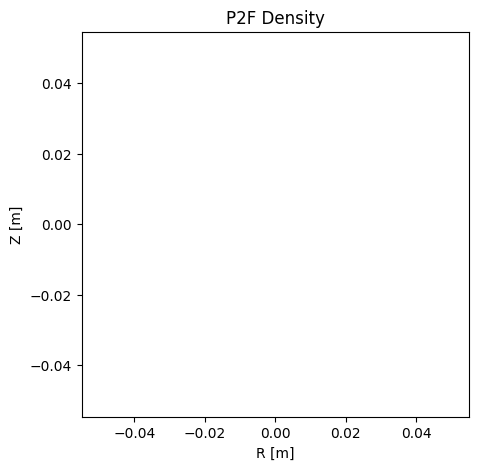

In [15]:
# plot the density integrated 
fig, ax = plt.subplots(figsize=(5,5))

ax.axis('equal')
ax.set_xlabel('R [m]')
ax.set_ylabel('Z [m]')
ax.set_title('P2F Density')

# convert from 1/cm^3 to 1/m^3
contour = ax.contourf(mcgo_pp.p2f_rbin_centers, mcgo_pp.p2f_zbin_centers, density2d.T, levels=100, cmap='jet')
fig.colorbar(contour, ax=ax, label=r'Density [m$^{-3}$]')
ax.plot(mcgo_pp.eqdsk["rlim"], mcgo_pp.eqdsk["zlim"], color="red", linewidth=1)
ax.plot(mcgo_pp.eqdsk["rbbbs"], mcgo_pp.eqdsk["zbbbs"], color="black", linewidth=1, linestyle='--')

# iRcheck = 27
# iZcheck = 0
# ax.scatter(Rden[iRcheck], Zden[iZcheck], color='red', marker='*')
# print(density2d[iRcheck, iZcheck])

ax.axhline(y=1.07, color='purple', linewidth='1')
ax.axhline(y=-1.26, color='purple', linewidth='1')
ax.axvline(x=1.022, color='purple', linewidth='1')
ax.axvline(x=2.317, color='purple', linewidth='1')

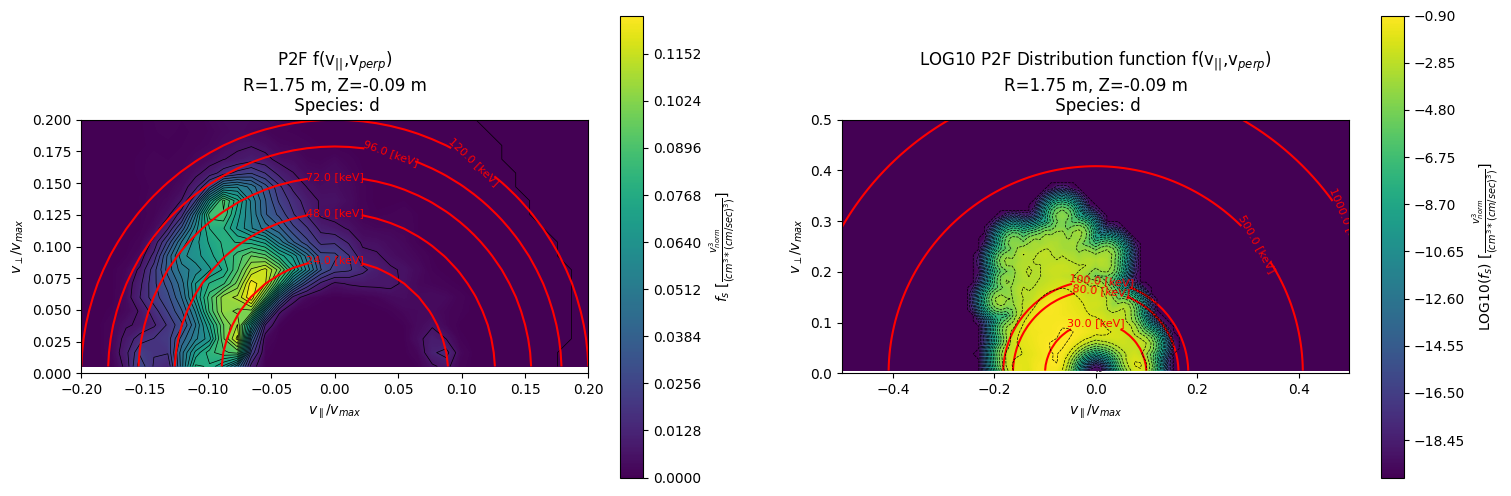

max(f): 0.1255839616060257


In [31]:
# plot the velocity distribution function 
iR = 71
iZ = 64
mcgo_pp.p2f_plot_distribution_function_at_RZ(
        R_index=iR,
        Z_index=iZ,
        v_norm_over_v_max=0.2,
        log_scale_axis_multiple=2.5,
        log_clip_level=1e-20,
        figsize=(18, 6),
        cmap="viridis",
        num_energy_levels=6,
        energy_levels_linear=None,
        energy_levels_log=[30, 80, 100, 500, 1000],
        energy_color="red",
        return_plot=False,
        use_interpolated_rho=False,
        rho_to_interpolate_to=None,
        plot_trapped_passing=False)

f_s_RZ, VPAR, VPERP, R, Z = mcgo_pp.p2f_get_distribution_function_at_RZ(indexR=iR, indexZ=iZ)
print(f'max(f): {np.max(f_s_RZ)}')

['   90   86\n']


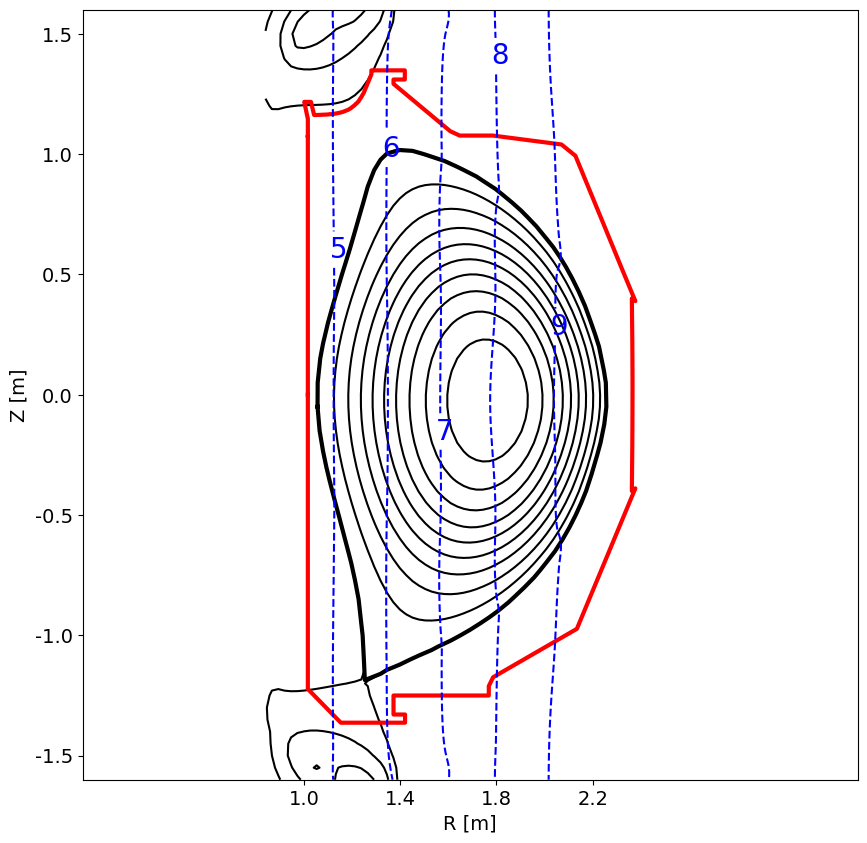

In [20]:
orbit_plot_obj = Orbit_Plotter(eqdsk_file=eqdsk_file, species='d')
orbit_plot_obj.plot_cyclotron_harmonics(
        frequency=96e6,
        harmonics=[5,6,7,8,9],
        species_mass=orbit_plot_obj.species_dict['d']['mass'],
        species_charge=orbit_plot_obj.species_dict['d']['charge'],
        r_resolution=200,
        z_resolution=200,
        levels=[.1,.2,.3,.4,.5,.6, .7,.8,.9,1],
        fontsize=14,
        figsize=(10, 10),
        harmonic_color="blue",
        return_plot=False,
        xticks=[1.0, 1.4, 1.8, 2.2],
    )

In [21]:
print(orbit_plot_obj.eqdsk_with_B_info["bzrz"].shape)
print(orbit_plot_obj.eqdsk_with_B_info["rgrid"].shape)
print(orbit_plot_obj.eqdsk_with_B_info["zgrid"].shape)

orbit_plot_obj.bz_interp((1.9,0))

(65, 65)
(65,)
(65,)


array(-0.11386442)

In [22]:
r0 = np.array([2.2, 0, 0])
# Ekev = 80
# vth = np.sqrt(Ekev * 1000 * 1.6022e-19 * 2 / (orbit_plot_obj.species_dict['d']['mass']))
# v0 = np.array([vth/np.sqrt(3), 1.0*vth/np.sqrt(3), vth/np.sqrt(3)])
Ekev = 80
vth = np.sqrt(Ekev * 1000 * 1.6022e-19 * 2 / (orbit_plot_obj.species_dict['d']['mass']))
v0 = np.array([vth/np.sqrt(3), 1.0*vth/np.sqrt(3), vth/np.sqrt(3)])
xarray, yarray, zarray = orbit_plot_obj.run_boris(r0=r0, v0=v0, nt=5000, dt=1e-8) # 5000 for case

In [23]:
r0 = np.array([2.2, 0, 0])
# Ekev = 80
# vth = np.sqrt(Ekev * 1000 * 1.6022e-19 * 2 / (orbit_plot_obj.species_dict['d']['mass']))
# v0 = np.array([vth/np.sqrt(3), 1.0*vth/np.sqrt(3), vth/np.sqrt(3)])
Ekev = .1
vth = np.sqrt(Ekev * 1000 * 1.6022e-19 * 2 / (orbit_plot_obj.species_dict['d']['mass']))
v0 = np.array([vth/np.sqrt(3), 1.0*vth/np.sqrt(3), vth/np.sqrt(3)])
xarray2, yarray2, zarray2 = orbit_plot_obj.run_boris(r0=r0, v0=v0, nt=5000, dt=5e-8) # 50000 for case

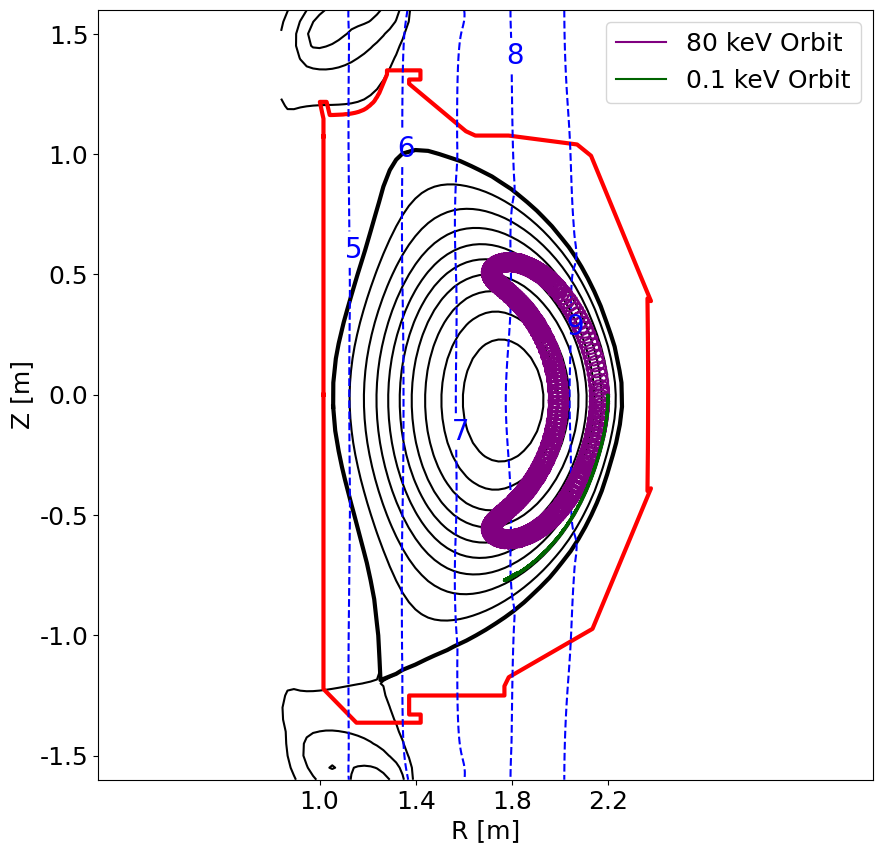

In [24]:

fig, ax = orbit_plot_obj.plot_cyclotron_harmonics(
        frequency=96e6,
        harmonics=[5,6,7,8,9],
        species_mass=orbit_plot_obj.species_dict['d']['mass'],
        species_charge=orbit_plot_obj.species_dict['d']['charge'],
        r_resolution=200,
        z_resolution=200,
        levels=[.1,.2,.3,.4,.5,.6, .7,.8,.9,1],
        fontsize=18,
        figsize=(10, 10),
        harmonic_color="blue",
        return_plot=True,
        xticks=[1.0, 1.4, 1.8, 2.2],
    )

ax.plot(np.sqrt(xarray**2 + yarray**2), zarray, color='purple', label='80 keV Orbit')
ax.plot(np.sqrt(xarray2**2 + yarray2**2), zarray2, color='darkgreen', label='0.1 keV Orbit')
ax.legend(fontsize=18)
# plt.plot(np.sqrt(xarray**2 + yarray**2),zarray)
# plt.axis('equal')

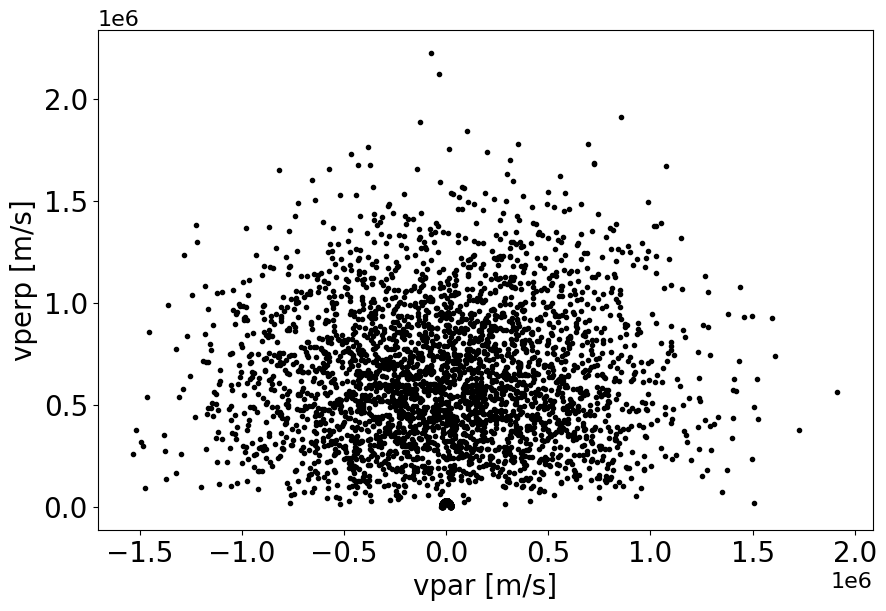

In [25]:
mcgo_pp.plot_bin_particles_RZ(NR=16, NZ=16, i=8, j=8, figsize=(10,10), fontsize=20)

In [26]:
# manually check derivatives of the p2f distribution of particles 

def read_f_rzvv_nc(filename):
    """
    Read f_rzvv from NetCDF (p2f convention) and return arrays in Python order:
        f_rzvv.shape = (nR, nZ, nVper, nVpar)

    Parameters
    ----------
    filename : str
        Path to .nc file

    Returns
    -------
    R_centers, Z_centers, vPer_centers, vPar_centers : 1D numpy arrays
    f_rzvv : 4D numpy array, shape (nR, nZ, nVper, nVpar)
    """
    with Dataset(filename, "r") as nc:
        R = nc.variables["R_binCenters"][:]
        Z = nc.variables["z_binCenters"][:]
        vPer = nc.variables["vPer_binCenters"][:]
        vPar = nc.variables["vPar_binCenters"][:]

        f_nc = nc.variables["f_rzvv"][:]  # stored as (vPar, vPer, Z, R)

    # Reorder to Python natural (R,Z,vPer,vPar)
    f_python = np.transpose(f_nc, (3, 2, 1, 0))

    return R, Z, vPer, vPar, f_python

# testing out my numerical derivatives 
def deriv_dfdvperp(f_rzvv, vPer, i_r, i_z):
    """
    df/dvper with f_rzvv shaped (n_vpar, n_vper, n_z, n_r).
    i_r, i_z are indices in R,Z (Python 0-based).
    Returns dfdvper slice of shape (n_vpar, n_vper).
    """
    n_r, n_z, n_vper, n_vpar = f_rzvv.shape
    dfdvper_slice = np.zeros((n_vper, n_vpar))

    for ivpar in range(n_vpar):
        for ivper in range(n_vper):
            if 0 < ivper < n_vper-1:
                dfdvper_slice[ivper, ivpar] = (
                    f_rzvv[i_r, i_z, ivper+1, ivpar] -
                    f_rzvv[i_r, i_z, ivper-1, ivpar]
                ) / (vPer[ivper+1] - vPer[ivper-1])

            elif ivper == 0 or ivper == n_vper-1:
                dfdvper_slice[ivper, ivpar] = 0.0

    return dfdvper_slice


def deriv_dfdvpar(f_rzvv, vPar, i_r, i_z):
    """
    df/dvpar with f_rzvv shaped (n_vpar, n_vper, n_z, n_r).
    i_r, i_z are indices in R,Z (Python 0-based).
    Returns dfdvpar slice of shape (n_vpar, n_vper).
    """
    n_r, n_z, n_vper, n_vpar = f_rzvv.shape
    dfdvpar_slice = np.zeros((n_vper, n_vpar))

    for ivper in range(n_vper):
        for ivpar in range(n_vpar):
            if 0 < ivpar < n_vpar-1:
                dfdvpar_slice[ivper, ivpar] = (
                    f_rzvv[i_r, i_z, ivper, ivpar+1] -
                    f_rzvv[i_r, i_z, ivper, ivpar-1]
                ) / (vPar[ivpar+1] - vPar[ivpar-1])

            elif ivpar == 0 or ivpar == n_vpar-1:
                dfdvpar_slice[ivper, ivpar] = 0.0

    return dfdvpar_slice

In [27]:
R, Z, vPer, vPar, f_saved = read_f_rzvv_nc(filename='/home/jacobvandelindt/aorsa_cql_mcgo_toolkit/shots/147634/p2f.nc')

print("Shapes:")
print("R:", R.shape)
print("Z:", Z.shape)
print("vPer:", vPer.shape)
print("vPar:", vPar.shape)
print("np.max(np.abs(vPar))",np.max(np.abs(vPar)))
print("f_saved:", f_saved.shape)  # should be (nR, nZ, nVper, nVpar)

print(np.isnan(f_saved.shape).any())

print('max f_rzvv:', np.max(f_saved))
print('min f_rzvv:', np.min(f_saved))

Shapes:
R: (128,)
Z: (128,)
vPer: (65,)
vPar: (129,)
np.max(np.abs(vPar)) 5953488.5
f_saved: (128, 128, 65, 129)
False
max f_rzvv: 9.008406
min f_rzvv: 0.0


In [ ]:
dfdvpar_all = np.zeros_like(f_saved)
dfdvper_all = np.zeros_like(f_saved)

for iR in range(f_saved.shape[0]):
    print(iR/R.shape[0], '% complete')
    for iZ in range(f_saved.shape[1]):
        dfdvpar_all[iR, iZ] = deriv_dfdvpar(f_saved, vPar, iR, iZ)
        dfdvper_all[iR, iZ] = deriv_dfdvperp(f_saved, vPer, iR, iZ)

0.0 % complete
0.0078125 % complete
0.015625 % complete
0.0234375 % complete
0.03125 % complete
0.0390625 % complete
0.046875 % complete
0.0546875 % complete
0.0625 % complete
0.0703125 % complete
0.078125 % complete
0.0859375 % complete
0.09375 % complete
0.1015625 % complete
0.109375 % complete


In [ ]:
# now, calculate the parallel derivative. R,Z doesnt matter

nan_found = False
for iR in range(R.shape[0]):
    for iZ in range(Z.shape[0]):
        dfdvpar = deriv_dfdvpar(f_rzvv=f_saved, vPar=vPar, i_r=iR, i_z=iZ)
        dfdvper = deriv_dfdvperp(f_rzvv=f_saved, vPer=vPer, i_r=iR, i_z=iZ)

        if np.isnan(dfdvper).any() or np.isnan(dfdvpar).any():
            print("NaN at iR:", iR, "iZ:", iZ)
            nan_found = True
            break

    if nan_found:
        break
        # print("Any NaNs in dfdvper?", np.isnan(dfdvper).any())
        # print("Any NaNs in dfdvpar?", np.isnan(dfdvpar).any())

KeyboardInterrupt: 

In [ ]:
print(dfdvpar)
print("df/dvper slice:", dfdvper.shape)  # (n_vpar, n_vper)
print("df/dvpar slice:", dfdvpar.shape)  # (n_vpar, n_vper)

print("Any NaNs in dfdvper?", np.isnan(dfdvper).any())
print("Any NaNs in dfdvpar?", np.isnan(dfdvpar).any())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
df/dvper slice: (65, 129)
df/dvpar slice: (65, 129)
Any NaNs in dfdvper? False
Any NaNs in dfdvpar? False


In [ ]:
dfdvpar =  deriv_dfdvpar(f_rzvv=f_saved, vPar=vPar/np.max(vPar), i_r=60, i_z=10)
dfdvper =  deriv_dfdvperp(f_rzvv=f_saved, vPer=vPer/np.max(vPar), i_r=60, i_z=10)

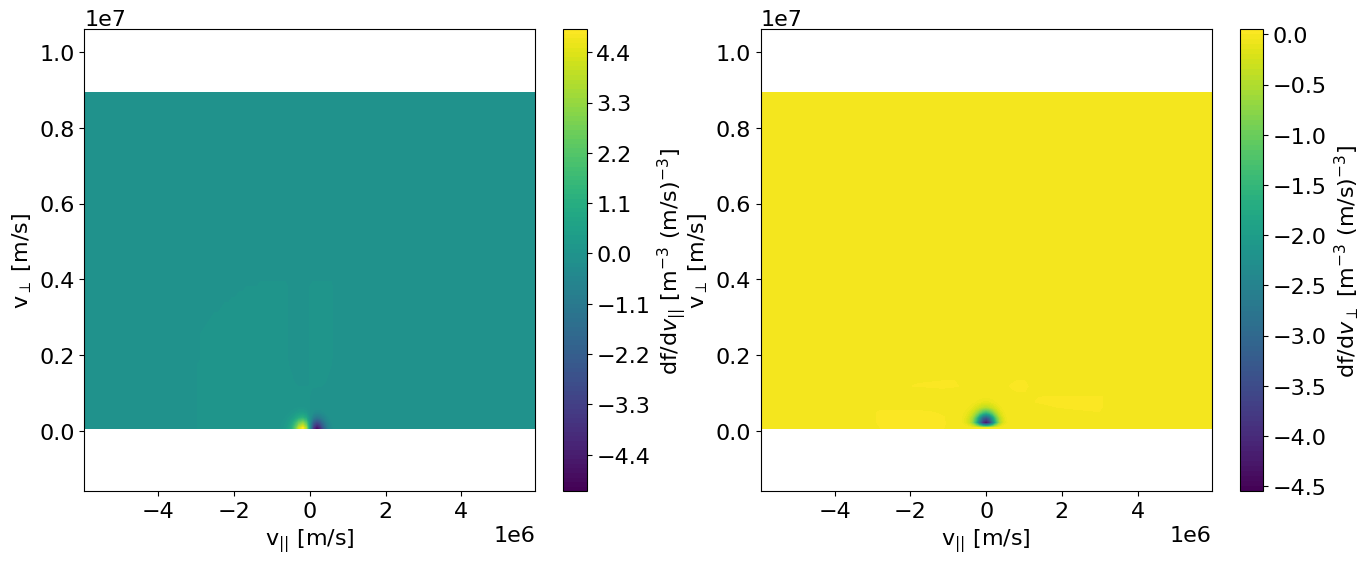

In [ ]:
VPAR, VPER = np.meshgrid(vPar, vPer)
fig, ax = plt.subplots(1,2, figsize=(16,6))
cont = ax[0].contourf(VPAR, VPER, dfdvpar, levels=100, cmap="viridis")
ax[0].axis('equal')
# Add colorbar
cbar = fig.colorbar(cont, ax=ax[0])
cbar.set_label(r"df/d$v_{||}$ [m$^{-3}$ (m/s)$^{-3}$]")   # optional label
ax[0].set_xlabel(r'v$_{||}$ [m/s]')
ax[0].set_ylabel(r'v$_{\perp}$ [m/s]')

cont = ax[1].contourf(VPAR, VPER, dfdvper, levels=100, cmap="viridis")
ax[1].axis('equal')
# Add colorbar
cbar = fig.colorbar(cont, ax=ax[1])
cbar.set_label(r"df/d$v_{\perp}$ [m$^{-3}$ (m/s)$^{-3}$]")  # optional label
ax[1].set_xlabel(r'v$_{||}$ [m/s]')
ax[1].set_ylabel(r'v$_{\perp}$ [m/s]')

fac = 10